In [2]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries to split data, impute missing values 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_excel('Tourism.xlsx', sheet_name=1)

In [4]:
# Replace Fe Male with Female in the Gender Column
data.replace(to_replace="Fe Male", value='Female', inplace=True)

In [5]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [6]:
#Drop Columns that are customer interaction data, these are not strictly Customer Data and while useful information are not pertinent to customer only model
data.drop(['DurationOfPitch','NumberOfFollowups','ProductPitched','PitchSatisfactionScore'], axis = 1, inplace=True)

In [7]:
# Replace missing values with the mean
data['MonthlyIncome'].fillna(int(data['MonthlyIncome'].mean()), inplace=True)
data['Age'].fillna(int(data['Age'].mean()), inplace=True)
data['NumberOfTrips'].fillna(int(data['NumberOfTrips'].mean()), inplace=True)
data['NumberOfChildrenVisiting'].fillna(int(data['NumberOfChildrenVisiting'].mean()), inplace=True)
data['PreferredPropertyStar'].fillna(int(data['PreferredPropertyStar'].mean()), inplace=True)

In [8]:
# Drop all rows with missing values left in the data set
data.dropna(inplace=True)

In [9]:
# Checking to make sure all null values have been treated
data.isnull().sum().sort_values(ascending=False)

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [10]:
#   Treat outliers in the Number of Trips and Monthly Income columns
data['NumberOfTrips'] = np.where(data['NumberOfTrips'] >= 6, 6, data['NumberOfTrips'])
data['MonthlyIncome'] = np.where(data['MonthlyIncome'] >= 40000, 23619.853491 , data['MonthlyIncome'])

In [11]:
#   Lets do one last check before moving on
data.isnull().T.any().T.sum()

0

In [12]:
# Get Dummies for the dataset
one_hots = ['TypeofContact','Occupation','Gender','MaritalStatus','Designation']
data=pd.get_dummies(data, columns=one_hots)

In [13]:
#creating a copy of the dataset to quickly refresh the data if I break something during testing
refresh = data.copy()

In [14]:
X = data.drop("ProdTaken", axis=1)
y = data.pop("ProdTaken")

In [15]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [16]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("")
print("---------------------------------------")
print("")
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("")
print("---------------------------------------")
print("")
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3404, 27)
Shape of test set :  (1459, 27)

---------------------------------------

Percentage of classes in training set:
0    0.804935
1    0.195065
Name: ProdTaken, dtype: float64

---------------------------------------

Percentage of classes in test set:
0    0.826594
1    0.173406
Name: ProdTaken, dtype: float64


In [66]:
# Function to compute metrics 
def model_performance_classification_sklearn(model, x, y):

    prediction = model.predict(x)

    accuracy = accuracy_score(y, prediction)
    recall = recall_score(y, prediction)
    precision = precision_score(y, prediction)
    f1 = f1_score(y, prediction)

    performance = pd.DataFrame({"Accuracy": accuracy,"Recall": recall,"Precision": precision,"F1": f1,},index=[0],)

    return performance

In [67]:
# Fitting the Bagging Classifier on the training set
bagging = BaggingClassifier(random_state=1)
bagging.fit(X_train, y_train)

# Predicting the train set
y_train_prediction_bagging = bagging.predict(X_train)

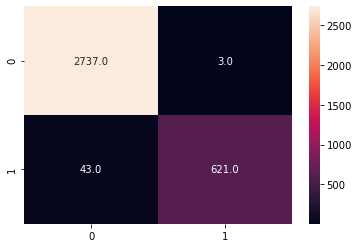

In [68]:
sns.heatmap(confusion_matrix(y_train,y_train_prediction_bagging),annot=True,fmt='.1f')
plt.show()

In [69]:
#Calculating different metrics
bagging_train_perf = model_performance_classification_sklearn(bagging,X_train,y_train)
bagging_test_perf = model_performance_classification_sklearn(bagging,X_test,y_test)
bagging_perf = bagging_train_perf.append(bagging_test_perf,ignore_index=True)
bagging_perf.index = ['Training','Test']
bagging_perf.head()

,Accuracy,Recall,Precision,F1
Training,0.986486,0.935241,0.995192,0.964286
Test,0.878684,0.470356,0.734568,0.573494


In [70]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train,y_train)

# Predicting the train set
y_train_prediction_rf = rf.predict(X_train)

In [71]:
rf_train_perf = model_performance_classification_sklearn(rf,X_train,y_train)
rf_test_perf = model_performance_classification_sklearn(rf,X_test,y_test)
rf_perf = rf_train_perf.append(rf_test_perf,ignore_index=True)
rf_perf.index = ['Training','Test']
rf_perf.head()

,Accuracy,Recall,Precision,F1
Training,1.000000,1.000000,1.000000,1.000000
Test,0.884853,0.454545,0.793103,0.577889


In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [72]:
##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True): #------------------------- DO WE NEED FLAG? 
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[]
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True: 
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
    
    # returning the list with train and test scores
    return score_list

In [73]:
get_model_score(bagging)

R-sqaure on training set :  0.9139345703983819
R-square on test set :  0.1536290877627673
RMSE on training set :  0.11624763874381928
RMSE on test set :  0.34830442122137606


[0.9139345703983819,
 0.1536290877627673,
 0.11624763874381928,
 0.34830442122137606]

##### Super Deluxe Package Customer Profile Analysis

1) Very few customers pick the Super Deluxe Package <br>
2) The largest range of customers is between 40 - 45 <br>
3) Most customers will only almost exclusively visit tier 3 cities <br>
4) Most customers will need a pitch of less than 20 minutes <br>
5) On average it will take 3 follow ups to close the deal <br>
6) Most customers have a monthly income between 28,000 - 32,000 <br>
7) AVPs are the only customers picking this package <br>
8) 80% of customers were company invited <br>

--------------------------------------------------

### Interesting thoughts on customers as a whole

- Each package only has 1 type of customer, this give us very easy to define targeting information of customers
- The vast majority of our customers self iniated contact, our marketing may not be very effective
- The basic package is by far our biggest seller
- Few trips are to tier 2 cities
- Very few people taking these trips are free lancers and may not be a good target
- Very few trips were take to visit 1 or 5 people, most trips are taken to visit 2-4 people
- 50% of customers are between 31 - 44
- The average pitch was 15 minutes

### Bagging
- **Bagging:** The Accuracy between the two sets is decent but there are massive disparities between Reacall and F1 in train and test set. Precision could also be closer betweent the two data sets.
- **Random Forest:** The difference in accuracy between the two sets is slightly larger here. Recall and F1 both have slightly larger disparities when compared to bagging, precision is roughly the same. The Accuracy between the two sets is decent but there are massive disparities between Reacall and F1 in train and test set. Precision could also be closer betweent the two data sets. With similiarities between the two sets in the shape of the data but baggings predictions closer between train and test it maybe be the better predictor.
- **Decision Tree:** The difference in accuracy between the three sets is even larger here with decision tree having the largest disparity. Recall and F1 both have better disparities when compared to bagging, precision is has the largest disparity of any of the datasets. As the company wants to minimize false postiives so recall is our best metric here. This makes decision tree the best model of the three so far but that doesnt mean its a good one yet. 
- **Tuned Bagging:** Overall performance metrics are not considerably better and our recall has gotten worse
- **Tuned Random Forest:** We can see weve brought the recal between the test and training sets signficantly closer together but neither sets has a good result.
- ** Tuned Decision Tree:** Our measures are all very close between the training and test sets. However, recall is def not good. 


#### Bagging Important Features:
- MonthlyIncome
- Age
- Passport
- CityTier

### Boosting
- **Adaboost:** The recall on Adaboost is attroucious, Accuracy is ok, Precision is better than recall and F1 but not good.
- **Gradient Boost:** Very similar to Adaboost, Accuracy is strong but precision between train and test has a large disparity and recall is awful.
- **XGBoost:** Recall on the training set is extremely good and the best of the boosting methods so far for both train and test. However the 40% disparity in effectiveness between train and test lets us know something is off here. Accruacy and Precision are both some of the strongest nubmers weve seen. 
- **Stacking:** Stacking has a perforamance closer to XGBoost but is more computational heavy than XGBoost. 
- **Adaboost Tuned:** Numbers are much better but still not better than XGBoost
- **Gradient Boost Tuned:** Our recall is the worst here of all test sets

#### Boosting Important Features: 
- Monthly Income 
- Age
- Passport
- Designation_Executive

### Business Recommendations
Each package only has 1 type of customer, this give us very easy to define targeting information of customers
The vast majority of our customers self iniated contact, our marketing may not be very effective
The basic package is by far our biggest seller
Few trips are to tier 2 cities
Very few people taking these trips are free lancers and may not be a good target
Very few trips were take to visit 1 or 5 people, most trips are taken to visit 2-4 people
50% of customers are between 31 - 44
The average pitch was 15 minutes